# CAB420, Sequences, Example 1: Recurrent Neural Networks
Dr Simon Denman (s.denman@qut.edu.au)

# Overview

We've actually looked at a couple of methods for processing sequences already, though we didn't explicitly look at these in the context of working with sequential data. In summary:
* In week 3 when looking at classification, CAB420_Classification_Example_2_Multi_Class_Classification.ipynb explored classifying beer names. These are sequences of words, and to get this into a format we could work with we:
  * Used a word embedding model to tranform each word to a vector of some fixed size;
  * Concatenated all words in a beer name to obtain a feature;
  * Padded these features up to some length, and removed any long names, to ensure all beer names have the same length representation.
* In week 6 in the summary example CAB420_Summary_3_Text_Classification.ipynb, we used Bag-of-Words to transform our variable length phrase (in this case a tweet) into a fixed length histogram.
 
These two approaches haven't been that great in terms of performance, but perhaps more critically they also haven't really used/modelled the data as a "sequence". We'll now play with a recurrent neural networks, which will actually recieve and treat the data as a sequence.

## Too Long; Didn't Read:
* Recurrent Neural Networks are a type of neural network designed to operate over sequences
* Long Short Term Memory units are a type of RNN, that use an internal memory mechanism to keep track of what's happening in the sequence. This means that when processing the sequence, we keep track of what's happened so far, and pay attention to the temporal order of things
* With such networks, we can stack recurrent units like we do convolutional units, though we can run into problems with depth if we're not careful
* Ths usual rules for deep nets apply, we want lots of data, and need to be careful about overfitting

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

## The Data

We're using the same data we used back in the earlier summary example - twitter data. We have 160,000 tweets that have been havested. For each of these, the tweet has been classified as either positive or negative.

Compared to what we did last time though, we'll be taking a few more samples as we're training a NN.

In [2]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv')
print(tweets.head())

tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])
Y[Y > 0] = 1

num_samples = 60000
train_samples = 50000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]
print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

### Data Preperation

We need to get our data into something numeric. Previously when we've played with text data, this has meant:
* text embeddings
* bag of words

We'll use an embedding again, but rather than use gensim and train one there, we'll build one as part of our network (i.e. we'll let Keras do it). To do that, we need to tokensize our document, and build it into sequences of the same length by padding the sequences.

In [3]:
max_words = 50000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

In [4]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(test_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_X = pad_sequences(test_sequences, maxlen=max_length, padding='post')

## A Recurrent Neural Network
We're going to set this up much like our other networks, just with a couple of changes to the layers. The noteable difference are:
* Our input is now a sequence
* Rather than having our usual array of convolutional layers, we instead have an LSTM (long short-term memory) layer 

Note here that our first layer here is an embedding layer, which is where we'll learn the embedding that we want to use.

In [5]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_length))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           6400000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,451,521
Trainable params: 6,451,521
Non-

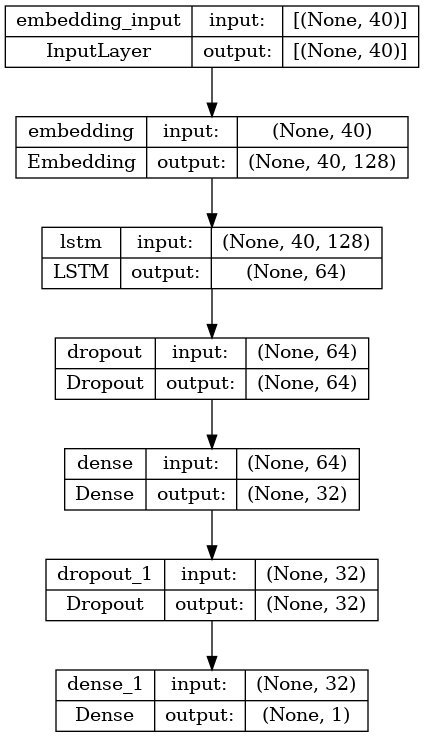

In [6]:
plot_model(model, show_shapes=True)

In [7]:
model.fit(train_padded_X, train_Y,
          batch_size=128,
          epochs=10,
          validation_data=[test_padded_X, test_Y])

Epoch 1/10
391/391 [==============================] - 26s 59ms/step - loss: 0.6933 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 2/10
391/391 [==============================] - 6s 15ms/step - loss: 0.5247 - accuracy: 0.7465 - val_loss: 0.4618 - val_accuracy: 0.7852
Epoch 3/10
391/391 [==============================] - 5s 12ms/step - loss: 0.3609 - accuracy: 0.8475 - val_loss: 0.4758 - val_accuracy: 0.7834
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2443 - accuracy: 0.9038 - val_loss: 0.6064 - val_accuracy: 0.7683
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 0.1651 - accuracy: 0.9404 - val_loss: 0.7368 - val_accuracy: 0.7623
Epoch 6/10
391/391 [==============================] - 4s 9ms/step - loss: 0.1107 - accuracy: 0.9609 - val_loss: 0.8332 - val_accuracy: 0.7687
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.0851 - accuracy: 0.9695 - val_loss: 0.9495 - val_accuracy: 0.7645
Ep

Now we can evaluate the model, and we see that it works pretty well.

313/313 - 1s - loss: 1.2306 - accuracy: 0.7533 - 685ms/epoch - 2ms/step
Test accuracy: 0.7533000111579895
313/313 [==============================] - 1s 2ms/step


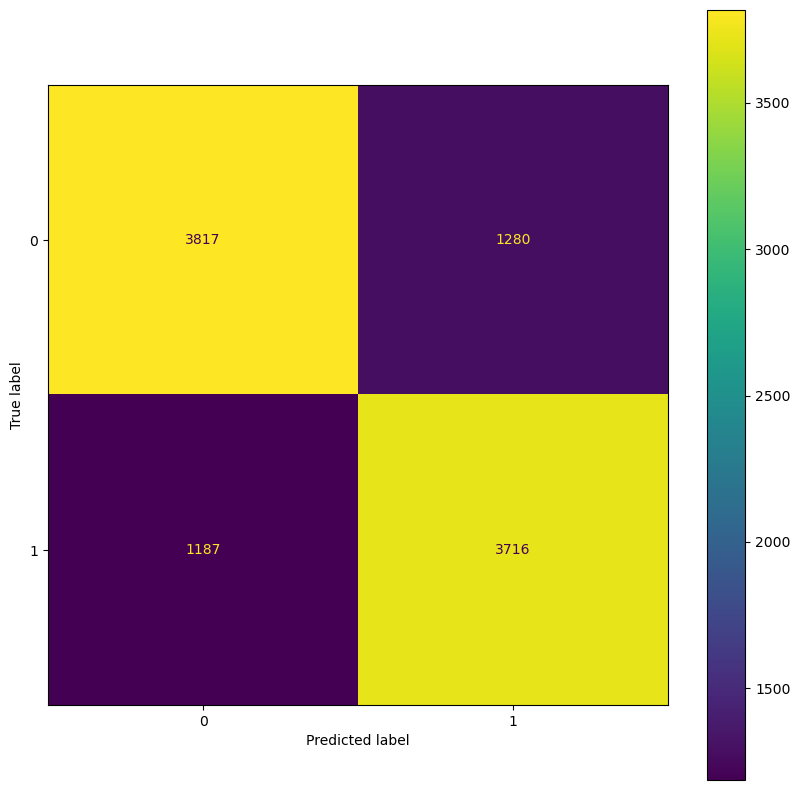

In [8]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    pred = pred >= 0.5
    
    cm = confusion_matrix(y_test, pred)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)

eval_model(model, test_padded_X, test_Y)

## Stacking LSTMs

With CNNs we could (usually, to a point) get better performance by stacking convolutional layers, learning increasingly rich features. We can do the same thing with LSTMs. The one thing we need to do for this is make sure that the early LSTM layers are producing a sequence output. This means that they learn an intermediate sequence representation, which then goes to another LSTM that outputs a final embedding, which we can then classify.

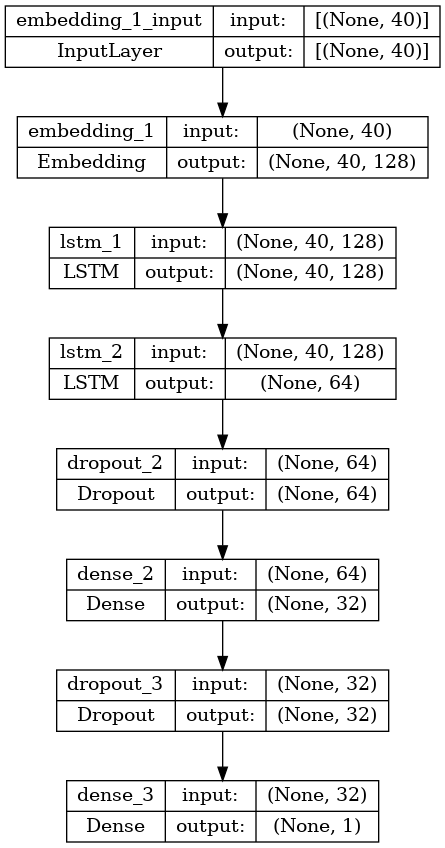

In [9]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
plot_model(model, show_shapes=True)

In [10]:
model.fit(train_padded_X, train_Y,
          batch_size=128,
          epochs=10,
          validation_data=[test_padded_X, test_Y])

Epoch 1/10
391/391 [==============================] - 19s 40ms/step - loss: 0.5815 - accuracy: 0.6730 - val_loss: 0.4753 - val_accuracy: 0.7798
Epoch 2/10
391/391 [==============================] - 6s 15ms/step - loss: 0.4073 - accuracy: 0.8282 - val_loss: 0.4693 - val_accuracy: 0.7842
Epoch 3/10
391/391 [==============================] - 5s 14ms/step - loss: 0.2974 - accuracy: 0.8814 - val_loss: 0.5605 - val_accuracy: 0.7748
Epoch 4/10
391/391 [==============================] - 6s 14ms/step - loss: 0.2117 - accuracy: 0.9191 - val_loss: 0.7318 - val_accuracy: 0.7618
Epoch 5/10
391/391 [==============================] - 5s 13ms/step - loss: 0.1499 - accuracy: 0.9444 - val_loss: 0.7150 - val_accuracy: 0.7604
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 0.1151 - accuracy: 0.9580 - val_loss: 1.0036 - val_accuracy: 0.7611
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 0.0909 - accuracy: 0.9673 - val_loss: 1.0757 - val_accuracy: 0.752

313/313 - 1s - loss: 1.4024 - accuracy: 0.7530 - 1s/epoch - 3ms/step
Test accuracy: 0.753000020980835
313/313 [==============================] - 1s 3ms/step


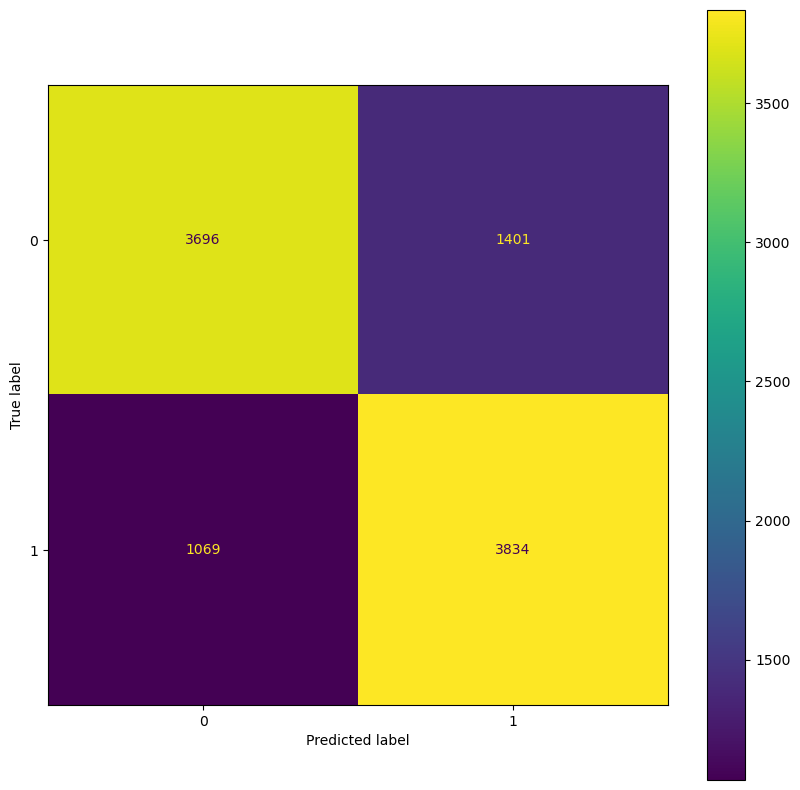

In [11]:
eval_model(model, test_padded_X, test_Y)

## Final Thoughts

RNNs, and LSTMs, are neural networks designed to process sequences. Importantly, when they process a sequence they consider each element in the sequence in turn, thus taking note of the order of the data.

Like CNNs, we can stack recurrent layers to extract higher order information from the data, however like CNNs we can go too deep and make it hard for the model to learn. In general, we use far fewer recurrent layers than we do convolutional layers.

In this example we've also limited ourselves to sequences of the same length, i.e. we've padded seqeunces to get a fixed length. We actually don't have to do this. While this makes our code much simpler (which is why we've done it), with recurrent networks we can use variable length sequences, which may better reflect the actual data in some instances.